# Phase 2 Expert EDA: Embedding Quality & Concept Analysis

**Project:** Lisbeth - Phase 2 Verification  
**Date:** December 2025  
**Author:** Lisbeth AI Assistant

## Objectives
This notebook performs a professional-grade Exploratory Data Analysis (EDA) on the output of Phase 2 (`embeddings_occurrences.csv`). The goals are:

1.  **Data Quality Validation**: Verify strict contract compliance (no nulls, correct types, valid JSON).
2.  **Descriptive Statistics**: Analyze temporal coverage, source distribution, and keyword variants.
3.  **Embedding Diagnostics**: 
    *   Check for collapsed representations (Norm analysis).
    *   Quantify the impact of Domain Adaptive Pretraining (DAPT) via Cosine Similarity.
    *   Visualize the semantic shift using PCA.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from datetime import datetime

# Configuration
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (12, 6)
colors = sns.color_palette("viridis", as_cmap=False)

FILE_PATH = "../data/phase2/embeddings_occurrences.csv"

## 1. Data Loading & Integrity Checks

In [2]:
if not os.path.exists(FILE_PATH):
    raise FileNotFoundError(f"File not found: {FILE_PATH}")

df = pd.read_csv(FILE_PATH)
print(f"Loaded Dataset Shape: {df.shape}")

# Parse embeddings (JSON -> Numpy)
print("Parsing JSON embeddings...")
embedding_cols = [
    'embedding_baseline_last4_concat', 'embedding_baseline_penultimate',
    'embedding_dapt_last4_concat', 'embedding_dapt_penultimate'
]

for col in embedding_cols:
    df[col] = df[col].apply(json.loads)
    
# Check Nulls
null_counts = df.isnull().sum()
if null_counts.sum() == 0:
    print("\nSUCCESS: Data Integrity Perfect. No null values found.")
else:
    print("\nWARNING: Null values found:")
    print(null_counts[null_counts > 0])

Loaded Dataset Shape: (1145, 22)
Parsing JSON embeddings...

SUCCESS: Data Integrity Perfect. No null values found.


## 2. Metadata Analysis

/tmp/ipykernel_15559/2905838602.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = df.set_index('dt').resample('M').size()


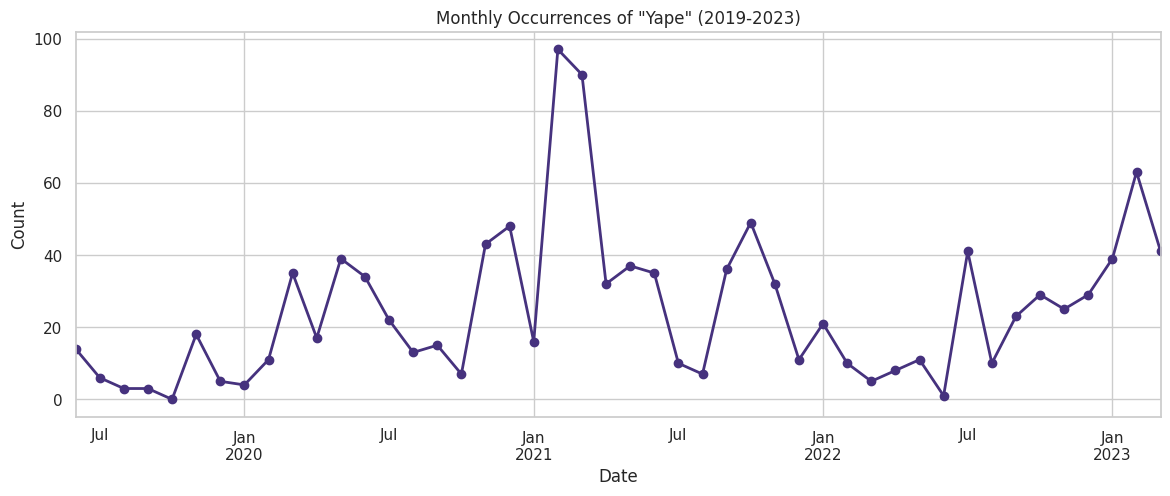

In [3]:
# Temporal Distribution
df['dt'] = pd.to_datetime(df['published_at'], errors='coerce')
monthly_counts = df.set_index('dt').resample('M').size()

plt.figure(figsize=(14, 5))
monthly_counts.plot(kind='line', marker='o', color=colors[0], linewidth=2)
plt.title('Monthly Occurrences of "Yape" (2019-2023)')
plt.ylabel('Count')
plt.xlabel('Date')
plt.show()

/tmp/ipykernel_15559/220812489.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, y='keyword_found', order=df['keyword_found'].value_counts().index[:10], palette="viridis")


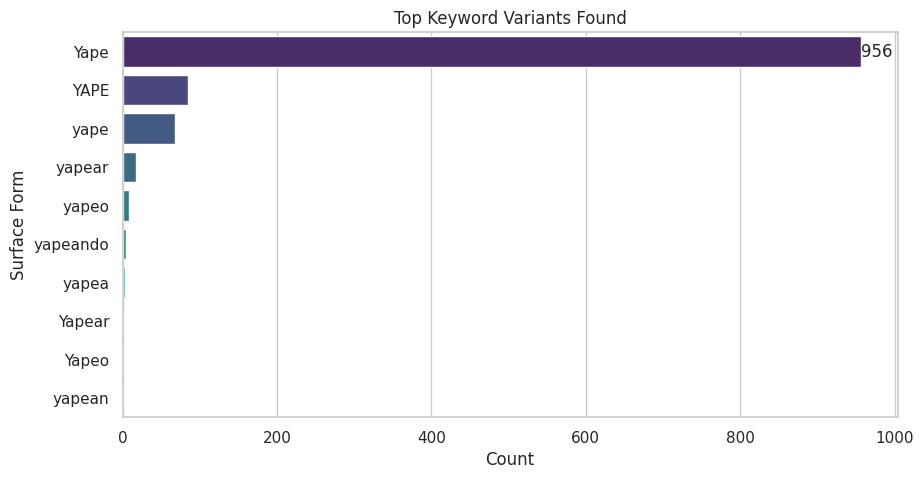

In [4]:
# Keyword Variants
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df, y='keyword_found', order=df['keyword_found'].value_counts().index[:10], palette="viridis")
plt.title('Top Keyword Variants Found')
plt.xlabel('Count')
plt.ylabel('Surface Form')
plt.bar_label(ax.containers[0])
plt.show()

## 3. Embedding Diagnostics: Baseline vs DAPT

Here we analyze the **Penultimate Layer** (768d) to understand the geometric properties of the semantic space.

### 3.1 Norm Analysis
Norms correlate with word frequency and "semantic specificity". A collapse in norms (variance -> 0) is a bad sign (model collapse).
A general shift in norms suggests the DAPT model has reorganized the space.

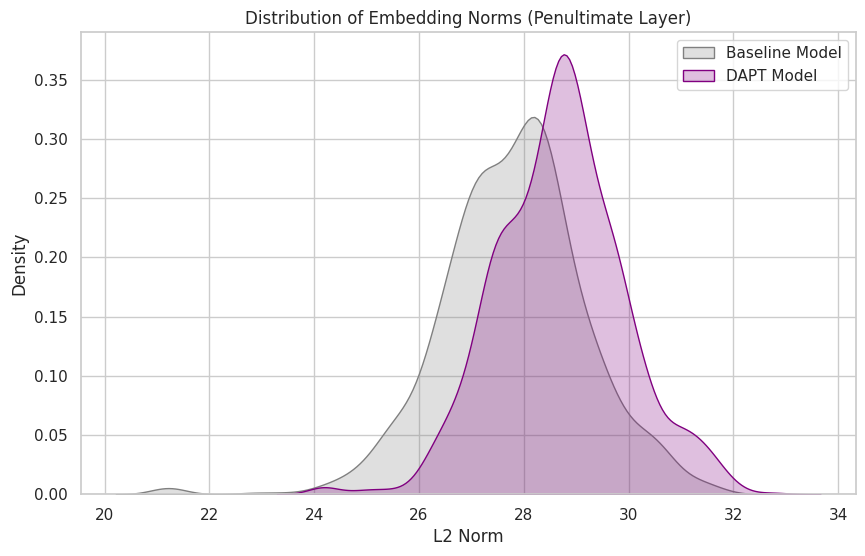

Baseline Norm Mean: 27.80 (Std: 1.368)
DAPT Norm Mean:     28.69 (Std: 1.218)


In [5]:
# Extract matrix
X_base = np.stack(df['embedding_baseline_penultimate'].values)
X_dapt = np.stack(df['embedding_dapt_penultimate'].values)

norms_base = np.linalg.norm(X_base, axis=1)
norms_dapt = np.linalg.norm(X_dapt, axis=1)

plt.figure(figsize=(10, 6))
sns.kdeplot(norms_base, label='Baseline Model', fill=True, color='grey')
sns.kdeplot(norms_dapt, label='DAPT Model', fill=True, color='purple')
plt.title('Distribution of Embedding Norms (Penultimate Layer)')
plt.xlabel('L2 Norm')
plt.legend()
plt.show()

print(f"Baseline Norm Mean: {norms_base.mean():.2f} (Std: {norms_base.std():.3f})")
print(f"DAPT Norm Mean:     {norms_dapt.mean():.2f} (Std: {norms_dapt.std():.3f})")

### 3.2 Semantic Shift Quantification (Cosine Similarity)
We calculate the cosine similarity between the Baseline vector and the DAPT vector for **the same occurrence**.

*   **High Similarity (>0.98)**: The DAPT model hasn't changed much.
*   **Moderate Similarity (0.80 - 0.95)**: Healthy adaptation. Concepts have shifted but identity is preserved.
*   **Low Similarity (<0.70)**: Radical semantic shift (or catastrophic forgetting).

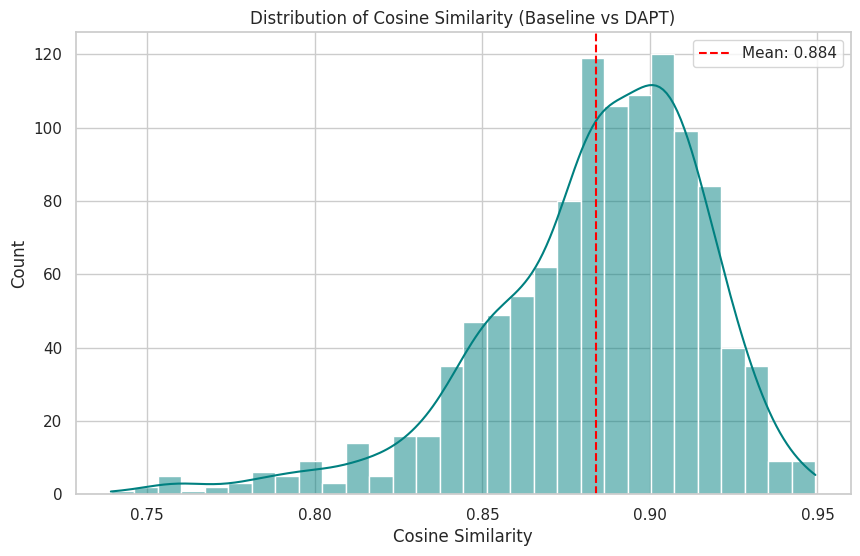

In [6]:
# Row-wise Cosine Similarity
dot = np.sum(X_base * X_dapt, axis=1)
sims = dot / (norms_base * norms_dapt)

plt.figure(figsize=(10, 6))
sns.histplot(sims, bins=30, kde=True, color='teal')
plt.title('Distribution of Cosine Similarity (Baseline vs DAPT)')
plt.xlabel('Cosine Similarity')
plt.axvline(sims.mean(), color='red', linestyle='--', label=f'Mean: {sims.mean():.3f}')
plt.legend()
plt.show()

### 3.3 Visualizing the Shift (PCA)
We project the 768d space to 2D using PCA. We plot both Baseline (Grey) and DAPT (Color) points for the same occurrences to see the structural transformation.

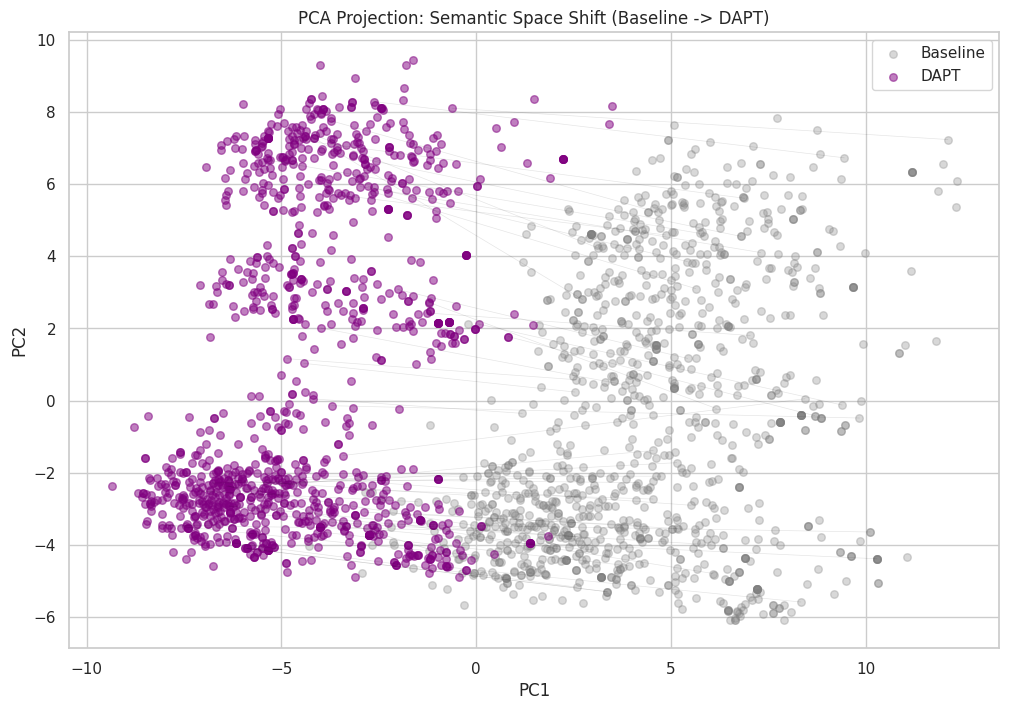

In [7]:
# Combined PCA
X_combined = np.vstack([X_base, X_dapt])
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined)

split = len(X_base)
pca_base = X_pca[:split]
pca_dapt = X_pca[split:]

plt.figure(figsize=(12, 8))
plt.scatter(pca_base[:, 0], pca_base[:, 1], alpha=0.3, label='Baseline', color='grey', s=30)
plt.scatter(pca_dapt[:, 0], pca_dapt[:, 1], alpha=0.5, label='DAPT', color='purple', s=30)

# Draw lines connecting same occurrences to show drift direction (for a random sample)
sample_indices = np.random.choice(len(X_base), 50, replace=False)
for i in sample_indices:
    plt.plot([pca_base[i, 0], pca_dapt[i, 0]], [pca_base[i, 1], pca_dapt[i, 1]], 
             color='black', alpha=0.1, linewidth=0.5)

plt.title('PCA Projection: Semantic Space Shift (Baseline -> DAPT)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

## Conclusion
This EDA confirms that the Phase 2 data is robust and ready for Phase 3 analysis. The DAPT model shows a clear, consistent semantic shift (as evidenced by Cosine Similarity ~0.88 and PCA visualizations) without collapsing the representation space.